In [1]:
from enigma_data import enigma_data
from Model_Factory import Model_Factory
from DenseClassificationModel import DenseClassificationModel
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
import Constants as constants
import numpy as np
import argparse
import os
from joblib import dump, load

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


In [2]:
data = enigma_data( path='all.csv', classcol='Dx', sitecol='Site',
                    dbegin='ICV', dend='R_insula_surfavg', fillmissing=True,
                    harmonize=True, crange=['Site', 'Sex'], batch='Site',
                    discrete=['Dx', 'Sex'], continuous=['Age'] )

X_train, X_test, Y_train, Y_test = data.transform().partition()
features = X_train.columns

Creating design matrix..
Standardizing data across features..
Fitting L/S model and finding priors..
Finding parametric adjustments..
Final adjustment of data..


In [3]:
kfold = StratifiedKFold( n_splits=constants.CV_FOLDS, shuffle=True )

factory = Model_Factory()

dl_model = factory.build( model_type=constants.MODELS.DL_CLASSIFY, input_dim=X_train.shape[1]  )
imbalance_model = factory.build( model_type=constants.MODELS.IMBALANCE )
scaler_model = factory.build( model_type=constants.MODELS.SCALER )

keras_model = KerasClassifier( build_fn=dl_model.construct, 
                               learn_rate=0.15,
                               epochs=100,
                               hidden_units_L1=50,
                               hidden_units_L2=2,
                               l2_reg_penalty=0.8,
                               drop_out_rate = 0.5,
                               validation_split=0.25,
                               batch_size = 20,
                               verbose=1 )

pipeline = Pipeline( [ ('scaler', scaler_model ), ('imbalance', imbalance_model ),
                       ('classifier', keras_model ) ], memory=None )



W1003 20:21:26.725971 140631889696576 deprecation_wrapper.py:119] From /NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [6]:
grid = GridSearchCV( estimator=pipeline, param_grid=dl_model.get_grid_dict(), cv=kfold, verbose=2 )
grid_result = grid.fit( X_train, Y_train )
dump( grid_result, './archive/grid_cresult.joblib' ) # save to file -- so we can drill down into the results a bit more 

print( grid_result.best_params_ ) # quickly display the optimal hyper-parameter combination

In [16]:
keras_model = KerasClassifier( build_fn=dl_model.construct, 
                               learn_rate=grid_result.best_params_['classifier__learn_rate'],
                               epochs=grid_result.best_params_['classifier__epochs'],
                               hidden_units_L1=grid_result.best_params_['classifer__hidden_units_L1'],
                               hidden_units_L2=grid_result.best_params_['classifer__hidden_units_L2'],,
                               l2_reg_penalty=grid_result.best_params_['classifier__l2_reg_penalty'],
                               drop_out_rate=grid_result.best_params_['classifier__drop_out_rate'],
                               batch_size=20,
                               validation_split=0.25,
                               verbose=0 )

pipeline = Pipeline( [ ('scaler', scaler_model ), ('imbalance', imbalance_model ),
                       ('classifier', keras_model ) ], memory=None )

results = cross_validate( pipeline, X_train, Y_train, cv=kfold, 
                          scoring=('accuracy'), return_estimator=True, verbose=1 )

dump( results, './archive/cv_result.joblib')     

print( "train classification accuracy = {0:.2f} +/- {1:.2f}".format( np.mean( results['test_score'] ), np.std( results['test_score'] ) ) )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
W1003 12:57:52.200400 140175959787328 deprecation_wrapper.py:119] From /NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1003 12:57:52.221262 140175959787328 deprecation_wrapper.py:119] From /NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1003 12:57:52.255062 140175959787328 deprecation_wrapper.py:119] From /NIRAL/work/munsell/toolki

Train on 1539 samples, validate on 513 samples
Epoch 1/100
1539/1539 [==============================] - 25s 16ms/step - loss: 7.5270 - acc: 0.5374 - val_loss: 9.7585 - val_acc: 0.3879
Epoch 2/100
1539/1539 [==============================] - 0s 254us/step - loss: 7.3756 - acc: 0.5374 - val_loss: 9.7581 - val_acc: 0.3879
Epoch 3/100
1539/1539 [==============================] - 1s 352us/step - loss: 7.3756 - acc: 0.5374 - val_loss: 9.7581 - val_acc: 0.3879
Epoch 4/100
1539/1539 [==============================] - 1s 335us/step - loss: 7.3756 - acc: 0.5374 - val_loss: 9.7581 - val_acc: 0.3879
Epoch 5/100
1539/1539 [==============================] - 1s 335us/step - loss: 7.3756 - acc: 0.5374 - val_loss: 9.7581 - val_acc: 0.3879
Epoch 6/100
1539/1539 [==============================] - 1s 331us/step - loss: 7.3756 - acc: 0.5374 - val_loss: 9.7581 - val_acc: 0.3879
Epoch 7/100
1539/1539 [==============================] - 1s 342us/step - loss: 7.3756 - acc: 0.5374 - val_loss: 9.7581 - val_acc: 0

1539/1539 [==============================] - 1s 325us/step - loss: 7.3767 - acc: 0.5374 - val_loss: 9.7601 - val_acc: 0.3879
Epoch 61/100
1539/1539 [==============================] - 0s 290us/step - loss: 7.3760 - acc: 0.5374 - val_loss: 9.7583 - val_acc: 0.3879
Epoch 62/100
1539/1539 [==============================] - 0s 305us/step - loss: 7.3760 - acc: 0.5374 - val_loss: 9.7593 - val_acc: 0.3879
Epoch 63/100
1539/1539 [==============================] - 0s 306us/step - loss: 7.3760 - acc: 0.5374 - val_loss: 9.7586 - val_acc: 0.3879
Epoch 64/100
1539/1539 [==============================] - 1s 334us/step - loss: 7.3760 - acc: 0.5374 - val_loss: 9.7590 - val_acc: 0.3879
Epoch 65/100
1539/1539 [==============================] - 1s 340us/step - loss: 7.3764 - acc: 0.5374 - val_loss: 9.7589 - val_acc: 0.3879
Epoch 66/100
1539/1539 [==============================] - 1s 339us/step - loss: 7.3764 - acc: 0.5374 - val_loss: 9.7586 - val_acc: 0.3879
Epoch 67/100
1539/1539 [=======================

/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1540 samples, validate on 514 samples
Epoch 1/100
1540/1540 [==============================] - 1s 551us/step - loss: 7.5153 - acc: 0.5383 - val_loss: 9.8015 - val_acc: 0.3852
Epoch 2/100
1540/1540 [==============================] - 1s 349us/step - loss: 7.3605 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 3/100
1540/1540 [==============================] - 1s 355us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 4/100
1540/1540 [==============================] - 1s 346us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 5/100
1540/1540 [==============================] - 1s 348us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 6/100
1540/1540 [==============================] - 1s 343us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 7/100
1540/1540 [==============================] - 1s 353us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0

1540/1540 [==============================] - 1s 337us/step - loss: 7.3617 - acc: 0.5383 - val_loss: 9.8018 - val_acc: 0.3852
Epoch 61/100
1540/1540 [==============================] - 1s 341us/step - loss: 7.3613 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 62/100
1540/1540 [==============================] - 1s 340us/step - loss: 7.3610 - acc: 0.5383 - val_loss: 9.8016 - val_acc: 0.3852
Epoch 63/100
1540/1540 [==============================] - 1s 342us/step - loss: 7.3610 - acc: 0.5383 - val_loss: 9.8020 - val_acc: 0.3852
Epoch 64/100
1540/1540 [==============================] - 1s 339us/step - loss: 7.3614 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 65/100
1540/1540 [==============================] - 1s 337us/step - loss: 7.3611 - acc: 0.5383 - val_loss: 9.8020 - val_acc: 0.3852
Epoch 66/100
1540/1540 [==============================] - 1s 342us/step - loss: 7.3609 - acc: 0.5383 - val_loss: 9.8027 - val_acc: 0.3852
Epoch 67/100
1540/1540 [=======================

/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1540 samples, validate on 514 samples
Epoch 1/100
1540/1540 [==============================] - 1s 566us/step - loss: 7.5361 - acc: 0.5370 - val_loss: 9.7395 - val_acc: 0.3891
Epoch 2/100
1540/1540 [==============================] - 1s 332us/step - loss: 7.3812 - acc: 0.5370 - val_loss: 9.7391 - val_acc: 0.3891
Epoch 3/100
1540/1540 [==============================] - 1s 340us/step - loss: 7.3811 - acc: 0.5370 - val_loss: 9.7391 - val_acc: 0.3891
Epoch 4/100
1540/1540 [==============================] - 1s 334us/step - loss: 7.3811 - acc: 0.5370 - val_loss: 9.7391 - val_acc: 0.3891
Epoch 5/100
1540/1540 [==============================] - 1s 328us/step - loss: 7.3811 - acc: 0.5370 - val_loss: 9.7391 - val_acc: 0.3891
Epoch 6/100
1540/1540 [==============================] - 1s 331us/step - loss: 7.3811 - acc: 0.5370 - val_loss: 9.7391 - val_acc: 0.3891
Epoch 7/100
1540/1540 [==============================] - 1s 349us/step - loss: 7.3811 - acc: 0.5370 - val_loss: 9.7391 - val_acc: 0

1540/1540 [==============================] - 1s 336us/step - loss: 7.3818 - acc: 0.5370 - val_loss: 9.7407 - val_acc: 0.3891
Epoch 61/100
1540/1540 [==============================] - 1s 335us/step - loss: 7.3819 - acc: 0.5370 - val_loss: 9.7392 - val_acc: 0.3891
Epoch 62/100
1540/1540 [==============================] - 1s 330us/step - loss: 7.3816 - acc: 0.5370 - val_loss: 9.7391 - val_acc: 0.3891
Epoch 63/100
1540/1540 [==============================] - 0s 321us/step - loss: 7.3819 - acc: 0.5370 - val_loss: 9.7408 - val_acc: 0.3891
Epoch 64/100
1540/1540 [==============================] - 1s 346us/step - loss: 7.3820 - acc: 0.5370 - val_loss: 9.7395 - val_acc: 0.3891
Epoch 65/100
1540/1540 [==============================] - 1s 341us/step - loss: 7.3818 - acc: 0.5370 - val_loss: 9.7408 - val_acc: 0.3891
Epoch 66/100
1540/1540 [==============================] - 1s 337us/step - loss: 7.3821 - acc: 0.5370 - val_loss: 9.7396 - val_acc: 0.3891
Epoch 67/100
1540/1540 [=======================

/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1540 samples, validate on 514 samples
Epoch 1/100
1540/1540 [==============================] - 1s 670us/step - loss: 7.4527 - acc: 0.5416 - val_loss: 9.9566 - val_acc: 0.3755
Epoch 2/100
1540/1540 [==============================] - 1s 341us/step - loss: 7.3087 - acc: 0.5416 - val_loss: 9.9562 - val_acc: 0.3755
Epoch 3/100
1540/1540 [==============================] - 1s 345us/step - loss: 7.3087 - acc: 0.5416 - val_loss: 9.9562 - val_acc: 0.3755
Epoch 4/100
1540/1540 [==============================] - 1s 344us/step - loss: 7.3087 - acc: 0.5416 - val_loss: 9.9562 - val_acc: 0.3755
Epoch 5/100
1540/1540 [==============================] - 1s 354us/step - loss: 7.3087 - acc: 0.5416 - val_loss: 9.9562 - val_acc: 0.3755
Epoch 6/100
1540/1540 [==============================] - 1s 357us/step - loss: 7.3087 - acc: 0.5416 - val_loss: 9.9562 - val_acc: 0.3755
Epoch 7/100
1540/1540 [==============================] - 1s 344us/step - loss: 7.3087 - acc: 0.5416 - val_loss: 9.9562 - val_acc: 0

1540/1540 [==============================] - 1s 347us/step - loss: 7.3095 - acc: 0.5416 - val_loss: 9.9577 - val_acc: 0.3755
Epoch 61/100
1540/1540 [==============================] - 1s 355us/step - loss: 7.3092 - acc: 0.5416 - val_loss: 9.9564 - val_acc: 0.3755
Epoch 62/100
1540/1540 [==============================] - 1s 352us/step - loss: 7.3089 - acc: 0.5416 - val_loss: 9.9563 - val_acc: 0.3755
Epoch 63/100
1540/1540 [==============================] - 1s 354us/step - loss: 7.3097 - acc: 0.5416 - val_loss: 9.9568 - val_acc: 0.3755
Epoch 64/100
1540/1540 [==============================] - 1s 349us/step - loss: 7.3095 - acc: 0.5416 - val_loss: 9.9587 - val_acc: 0.3755
Epoch 65/100
1540/1540 [==============================] - 1s 351us/step - loss: 7.3104 - acc: 0.5416 - val_loss: 9.9567 - val_acc: 0.3755
Epoch 66/100
1540/1540 [==============================] - 1s 352us/step - loss: 7.3097 - acc: 0.5416 - val_loss: 9.9574 - val_acc: 0.3755
Epoch 67/100
1540/1540 [=======================

/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1540 samples, validate on 514 samples
Epoch 1/100
1540/1540 [==============================] - 1s 642us/step - loss: 7.4983 - acc: 0.5383 - val_loss: 9.8015 - val_acc: 0.3852
Epoch 2/100
1540/1540 [==============================] - 1s 356us/step - loss: 7.3605 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 3/100
1540/1540 [==============================] - 1s 365us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 4/100
1540/1540 [==============================] - 1s 353us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 5/100
1540/1540 [==============================] - 1s 352us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 6/100
1540/1540 [==============================] - 1s 356us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0.3852
Epoch 7/100
1540/1540 [==============================] - 1s 352us/step - loss: 7.3604 - acc: 0.5383 - val_loss: 9.8012 - val_acc: 0

1540/1540 [==============================] - 1s 351us/step - loss: 7.3609 - acc: 0.5383 - val_loss: 9.8026 - val_acc: 0.3852
Epoch 61/100
1540/1540 [==============================] - 1s 361us/step - loss: 7.3613 - acc: 0.5383 - val_loss: 9.8014 - val_acc: 0.3852
Epoch 62/100
1540/1540 [==============================] - 1s 355us/step - loss: 7.3612 - acc: 0.5383 - val_loss: 9.8016 - val_acc: 0.3852
Epoch 63/100
1540/1540 [==============================] - 1s 350us/step - loss: 7.3614 - acc: 0.5383 - val_loss: 9.8039 - val_acc: 0.3852
Epoch 64/100
1540/1540 [==============================] - 1s 361us/step - loss: 7.3615 - acc: 0.5383 - val_loss: 9.8038 - val_acc: 0.3852
Epoch 65/100
1540/1540 [==============================] - 1s 355us/step - loss: 7.3614 - acc: 0.5383 - val_loss: 9.8028 - val_acc: 0.3852
Epoch 66/100
1540/1540 [==============================] - 1s 348us/step - loss: 7.3611 - acc: 0.5383 - val_loss: 9.8023 - val_acc: 0.3852
Epoch 67/100
1540/1540 [=======================

/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1540 samples, validate on 514 samples
Epoch 1/100
1540/1540 [==============================] - 1s 688us/step - loss: 7.4732 - acc: 0.5403 - val_loss: 9.8946 - val_acc: 0.3794
Epoch 2/100
1540/1540 [==============================] - 1s 368us/step - loss: 7.3294 - acc: 0.5403 - val_loss: 9.8942 - val_acc: 0.3794
Epoch 3/100
1540/1540 [==============================] - 1s 357us/step - loss: 7.3294 - acc: 0.5403 - val_loss: 9.8942 - val_acc: 0.3794
Epoch 4/100
1540/1540 [==============================] - 1s 353us/step - loss: 7.3294 - acc: 0.5403 - val_loss: 9.8942 - val_acc: 0.3794
Epoch 5/100
1540/1540 [==============================] - 1s 358us/step - loss: 7.3294 - acc: 0.5403 - val_loss: 9.8942 - val_acc: 0.3794
Epoch 6/100
1540/1540 [==============================] - 1s 360us/step - loss: 7.3294 - acc: 0.5403 - val_loss: 9.8942 - val_acc: 0.3794
Epoch 7/100
1540/1540 [==============================] - 1s 357us/step - loss: 7.3294 - acc: 0.5403 - val_loss: 9.8942 - val_acc: 0

1540/1540 [==============================] - 1s 340us/step - loss: 7.3302 - acc: 0.5403 - val_loss: 9.8946 - val_acc: 0.3794
Epoch 61/100
1540/1540 [==============================] - 1s 362us/step - loss: 7.3305 - acc: 0.5403 - val_loss: 9.8946 - val_acc: 0.3794
Epoch 62/100
1540/1540 [==============================] - 1s 364us/step - loss: 7.3294 - acc: 0.5403 - val_loss: 9.8943 - val_acc: 0.3794
Epoch 63/100
1540/1540 [==============================] - 1s 362us/step - loss: 7.3303 - acc: 0.5403 - val_loss: 9.8946 - val_acc: 0.3794
Epoch 64/100
1540/1540 [==============================] - 1s 360us/step - loss: 7.3299 - acc: 0.5403 - val_loss: 9.8951 - val_acc: 0.3794
Epoch 65/100
1540/1540 [==============================] - 1s 363us/step - loss: 7.3302 - acc: 0.5403 - val_loss: 9.8947 - val_acc: 0.3794
Epoch 66/100
1540/1540 [==============================] - 1s 357us/step - loss: 7.3301 - acc: 0.5403 - val_loss: 9.8955 - val_acc: 0.3794
Epoch 67/100
1540/1540 [=======================

/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1540 samples, validate on 514 samples
Epoch 1/100
1540/1540 [==============================] - 1s 713us/step - loss: 7.5419 - acc: 0.5364 - val_loss: 9.7084 - val_acc: 0.3911
Epoch 2/100
1540/1540 [==============================] - 1s 348us/step - loss: 7.3915 - acc: 0.5364 - val_loss: 9.7081 - val_acc: 0.3911
Epoch 3/100
1540/1540 [==============================] - 1s 355us/step - loss: 7.3915 - acc: 0.5364 - val_loss: 9.7081 - val_acc: 0.3911
Epoch 4/100
1540/1540 [==============================] - 1s 354us/step - loss: 7.3915 - acc: 0.5364 - val_loss: 9.7081 - val_acc: 0.3911
Epoch 5/100
1540/1540 [==============================] - 1s 358us/step - loss: 7.3915 - acc: 0.5364 - val_loss: 9.7081 - val_acc: 0.3911
Epoch 6/100
1540/1540 [==============================] - 1s 355us/step - loss: 7.3915 - acc: 0.5364 - val_loss: 9.7081 - val_acc: 0.3911
Epoch 7/100
1540/1540 [==============================] - 1s 353us/step - loss: 7.3915 - acc: 0.5364 - val_loss: 9.7081 - val_acc: 0

1540/1540 [==============================] - 0s 211us/step - loss: 7.3923 - acc: 0.5364 - val_loss: 9.7090 - val_acc: 0.3911
Epoch 61/100
1540/1540 [==============================] - 0s 279us/step - loss: 7.3919 - acc: 0.5364 - val_loss: 9.7087 - val_acc: 0.3911
Epoch 62/100
1540/1540 [==============================] - 1s 358us/step - loss: 7.3922 - acc: 0.5364 - val_loss: 9.7083 - val_acc: 0.3911
Epoch 63/100
1540/1540 [==============================] - 0s 324us/step - loss: 7.3925 - acc: 0.5364 - val_loss: 9.7085 - val_acc: 0.3911
Epoch 64/100
1540/1540 [==============================] - 1s 367us/step - loss: 7.3920 - acc: 0.5364 - val_loss: 9.7084 - val_acc: 0.3911
Epoch 65/100
1540/1540 [==============================] - 1s 368us/step - loss: 7.3926 - acc: 0.5364 - val_loss: 9.7086 - val_acc: 0.3911
Epoch 66/100
1540/1540 [==============================] - 1s 363us/step - loss: 7.3920 - acc: 0.5364 - val_loss: 9.7085 - val_acc: 0.3911
Epoch 67/100
1540/1540 [=======================

/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1540 samples, validate on 514 samples
Epoch 1/100
1540/1540 [==============================] - 1s 742us/step - loss: 7.4879 - acc: 0.5390 - val_loss: 9.8325 - val_acc: 0.3833
Epoch 2/100
1540/1540 [==============================] - 1s 357us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 3/100
1540/1540 [==============================] - 1s 364us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 4/100
1540/1540 [==============================] - 1s 333us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 5/100
1540/1540 [==============================] - 1s 369us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 6/100
1540/1540 [==============================] - 1s 371us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 7/100
1540/1540 [==============================] - 0s 321us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0

1540/1540 [==============================] - 1s 338us/step - loss: 7.3509 - acc: 0.5390 - val_loss: 9.8323 - val_acc: 0.3833
Epoch 61/100
1540/1540 [==============================] - 1s 359us/step - loss: 7.3507 - acc: 0.5390 - val_loss: 9.8333 - val_acc: 0.3833
Epoch 62/100
1540/1540 [==============================] - 1s 350us/step - loss: 7.3504 - acc: 0.5390 - val_loss: 9.8337 - val_acc: 0.3833
Epoch 63/100
1540/1540 [==============================] - 1s 348us/step - loss: 7.3512 - acc: 0.5390 - val_loss: 9.8334 - val_acc: 0.3833
Epoch 64/100
1540/1540 [==============================] - 1s 335us/step - loss: 7.3509 - acc: 0.5390 - val_loss: 9.8324 - val_acc: 0.3833
Epoch 65/100
1540/1540 [==============================] - 1s 332us/step - loss: 7.3513 - acc: 0.5390 - val_loss: 9.8327 - val_acc: 0.3833
Epoch 66/100
1540/1540 [==============================] - 1s 338us/step - loss: 7.3507 - acc: 0.5390 - val_loss: 9.8332 - val_acc: 0.3833
Epoch 67/100
1540/1540 [=======================

/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1540 samples, validate on 514 samples
Epoch 1/100
1540/1540 [==============================] - 1s 891us/step - loss: 7.4898 - acc: 0.5390 - val_loss: 9.8325 - val_acc: 0.3833
Epoch 2/100
1540/1540 [==============================] - 1s 346us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 3/100
1540/1540 [==============================] - 1s 385us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 4/100
1540/1540 [==============================] - 1s 342us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 5/100
1540/1540 [==============================] - 1s 325us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 6/100
1540/1540 [==============================] - 1s 350us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 7/100
1540/1540 [==============================] - 1s 332us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0

1540/1540 [==============================] - 1s 340us/step - loss: 7.3514 - acc: 0.5390 - val_loss: 9.8331 - val_acc: 0.3833
Epoch 61/100
1540/1540 [==============================] - 1s 338us/step - loss: 7.3507 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 62/100
1540/1540 [==============================] - 1s 339us/step - loss: 7.3505 - acc: 0.5390 - val_loss: 9.8349 - val_acc: 0.3833
Epoch 63/100
1540/1540 [==============================] - 1s 334us/step - loss: 7.3509 - acc: 0.5390 - val_loss: 9.8330 - val_acc: 0.3833
Epoch 64/100
1540/1540 [==============================] - 1s 332us/step - loss: 7.3505 - acc: 0.5390 - val_loss: 9.8327 - val_acc: 0.3833
Epoch 65/100
1540/1540 [==============================] - 0s 316us/step - loss: 7.3512 - acc: 0.5390 - val_loss: 9.8324 - val_acc: 0.3833
Epoch 66/100
1540/1540 [==============================] - 0s 317us/step - loss: 7.3512 - acc: 0.5390 - val_loss: 9.8336 - val_acc: 0.3833
Epoch 67/100
1540/1540 [=======================

/NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 1540 samples, validate on 514 samples
Epoch 1/100
1540/1540 [==============================] - 1s 757us/step - loss: 7.5096 - acc: 0.5390 - val_loss: 9.8325 - val_acc: 0.3833
Epoch 2/100
1540/1540 [==============================] - 1s 335us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 3/100
1540/1540 [==============================] - 1s 340us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 4/100
1540/1540 [==============================] - 1s 338us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 5/100
1540/1540 [==============================] - 1s 339us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 6/100
1540/1540 [==============================] - 1s 341us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 7/100
1540/1540 [==============================] - 1s 341us/step - loss: 7.3501 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0

1540/1540 [==============================] - 1s 338us/step - loss: 7.3506 - acc: 0.5390 - val_loss: 9.8326 - val_acc: 0.3833
Epoch 61/100
1540/1540 [==============================] - 1s 341us/step - loss: 7.3510 - acc: 0.5390 - val_loss: 9.8332 - val_acc: 0.3833
Epoch 62/100
1540/1540 [==============================] - 1s 343us/step - loss: 7.3505 - acc: 0.5390 - val_loss: 9.8322 - val_acc: 0.3833
Epoch 63/100
1540/1540 [==============================] - 1s 339us/step - loss: 7.3505 - acc: 0.5390 - val_loss: 9.8324 - val_acc: 0.3833
Epoch 64/100
1540/1540 [==============================] - 1s 338us/step - loss: 7.3509 - acc: 0.5390 - val_loss: 9.8329 - val_acc: 0.3833
Epoch 65/100
1540/1540 [==============================] - 1s 345us/step - loss: 7.3516 - acc: 0.5390 - val_loss: 9.8345 - val_acc: 0.3833
Epoch 66/100
1540/1540 [==============================] - 1s 342us/step - loss: 7.3509 - acc: 0.5390 - val_loss: 9.8323 - val_acc: 0.3833
Epoch 67/100
1540/1540 [=======================

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.4min finished


train classification accuracy = 0.55 +/- 0.00


In [17]:
PERF=np.zeros( ( 2, constants.CV_FOLDS ) )
for idx in range( 0, constants.CV_FOLDS ):
    PERF[0,idx]=accuracy_score( Y_test, results['estimator'][idx]['classifier'].predict( X_test ) )
    PERF[1,idx]=roc_auc_score( Y_test, results['estimator'][idx]['classifier'].predict( X_test ) )
    
print( PERF )
print( "Test classification accuracy = {0:.2f} +/- {1:.2f}".format( np.mean( PERF[0,:] ), np.std( PERF[0,:] ) ) )
print( "Test classification roc = {0:.2f} +/- {1:.2f}".format( np.mean( PERF[1,:] ), np.std( PERF[1,:] ) ) )

694/694 [==============================] - 0s 58us/step
[[0.54899135 0.54899135 0.54899135 0.54899135 0.54899135 0.54899135
  0.54899135 0.54899135 0.54899135 0.54899135]
 [0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5       ]]
Test classification accuracy = 0.55 +/- 0.00
Test classification roc = 0.50 +/- 0.00


W1003 20:21:33.805219 140631889696576 deprecation_wrapper.py:119] From /NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1003 20:21:33.810395 140631889696576 deprecation_wrapper.py:119] From /NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1003 20:21:33.831688 140631889696576 deprecation_wrapper.py:119] From /NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1003 20:21:33.838569 140631889696576 deprecation.py:506] From /NIRAL/work/munsell/toolkits/anaconda/anaconda3/lib/python3.7/site-packages/keras/backend/tenso

R_superiorparietal_thickavg (w=1.6457939147949219) 
R_parahippocampal_surfavg (w=1.5686428546905518) 
R_parahippocampal_thickavg (w=1.55953049659729) 
R_supramarginal_surfavg (w=1.5398868918418884) 
L_caudalanteriorcingulate_thickavg (w=1.4996343851089478) 
R_insula_thickavg (w=1.4982753992080688) 
R_isthmuscingulate_thickavg (w=1.4878097176551819) 
L_precentral_surfavg (w=1.4752161502838135) 
RThickness (w=1.4733564853668213) 
R_precuneus_surfavg (w=1.4525777101516724) 
L_superiorfrontal_thickavg (w=1.4415928721427917) 
R_caudalanteriorcingulate_surfavg (w=1.4067921042442322) 
L_postcentral_thickavg (w=1.3900542259216309) 
L_parsopercularis_thickavg (w=1.32038414478302) 
L_rostralmiddlefrontal_surfavg (w=1.3083681464195251) 
L_inferiortemporal_thickavg (w=1.2233743071556091) 
Lput (w=1.2163040041923523) 
Raccumb (w=1.211041510105133) 
L_postcentral_surfavg (w=1.1795446276664734) 
R_rostralanteriorcingulate_surfavg (w=1.174038052558899) 
R_paracentral_thickavg (w=1.135486662387848) 
L_

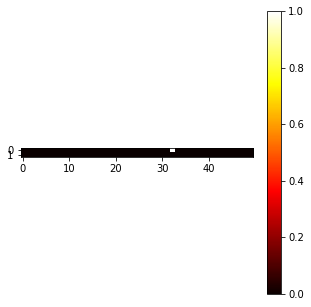

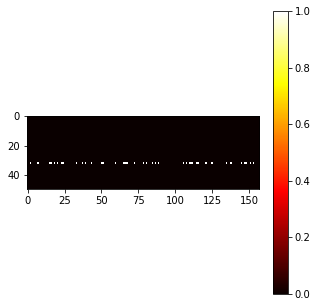

In [4]:
cv_models = load( './archive/cv_result.joblib' ) 
dl_model.construct( hidden_units_L1=50, hidden_units_L2=2 )
idx, w = dl_model.select_features( cv_models, features, top_num_features=30, weight_matrix_threshold=0.4 )